In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import random
import time
import os
from tqdm.auto import tqdm

# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp
import rasterio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2024) # Seed 고정

In [12]:
from glob import glob
img_dir = './images/*'
mask_dir = './annotations/*'
test_dir = './test_png/*'
imgs_names = glob(img_dir)
mask_names = glob(mask_dir)

print(len(glob(img_dir)))
print(len(glob(mask_dir)))

33575
33575
0


## 해당 Dataset의 Mean & Standard Deviation 구하기

In [13]:
# images_rgb = [np.array(Image.open(img).getdata()) / 255. for img in tqdm(imgs_names[:10000], total=10000)]
# # Each image_rgb is of shape (n, 3),
# # where n is the number of pixels in each image,
# # and 3 are the channels: R, G, B.

# means = []
# for image_rgb in tqdm(images_rgb, total=10000):
#     means.append(np.mean(image_rgb, axis=0))
# mu_rgb = np.mean(means, axis=0)  # mu_rgb.shape == (3,)

# variances = []
# for image_rgb in tqdm(images_rgb, total=10000):
#     var = np.mean((image_rgb - mu_rgb) ** 2, axis=0)
#     variances.append(var)
# std_rgb = np.sqrt(np.mean(variances, axis=0))  # std_rgb.shape == (3,)

# print(mu_rgb, std_rgb) # [0.61373651 0.61373651 0.61373651] [0.25629086 0.25629086 0.25629086]

'''
Mean = [0.15471383 0.20073772 0.15491631]
Std = [0.06136571 0.07249431 0.05826087]
'''

'\nMean = [0.15471383 0.20073772 0.15491631]\nStd = [0.06136571 0.07249431 0.05826087]\n'

In [14]:
IMAGE_PATH = './images/'
MASK_PATH = './annotations/'

In [15]:
n_classes = 2

def create_df():
    name = []
    for filename in imgs_names:
        name.append(filename.split('.')[1][7:])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  33575


In [16]:
#split data
X_train, X_val = train_test_split(df['id'].values, test_size=0.05, random_state=2024)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  31896
Val Size     :  1679


In [17]:
class LungDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [18]:
mean = [0.154, 0.200, 0.154]
std = [0.061, 0.072, 0.058]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), # For Outliers
                     A.HorizontalFlip(p=0.5),
                     A.VerticalFlip(p=0.5),
                     A.Rotate(limit=90, p=0.3, border_mode=cv2.BORDER_REPLICATE),
                    #  A.RandomRotate90(p=0.5),
                    #  A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                    #  A.GaussNoise()
                     ])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), # For Outliers
                   ])

#datasets
train_set = LungDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = LungDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6)

In [19]:
model = smp.UnetPlusPlus('efficientnet-b0', encoder_weights='imagenet', classes=1, activation=None, in_channels=3)

In [20]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.sigmoid(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [21]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.sigmoid(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = 1.0
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader, desc=f"Training Epoch {e}")):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            # print(output.size(), mask.size())
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader, desc=f"Validation")):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Dice loss is Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                not_improve = 0
                print('saving model...')
                torch.save(model.state_dict(), 'Best_Dice.pt')


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                print(f'Dice loss not Decrease for {not_improve} times')
                if not_improve == 10:
                    print('Dice not Decrease for 10 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    
    model.load_state_dict(torch.load('Best_mIoU.pt'))
    return model, history

In [23]:
max_lr = 1e-3
epoch = 1000
weight_decay = 1e-4

criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult = 1, eta_min = 1e-5)

model, history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

Validation: 100%|██████████| 53/53 [00:04<00:00, 11.37it/s]


Dice loss is Decreasing.. 1.000 >> 0.169 
saving model...
Epoch:1/1000.. Train Loss: 0.323.. Val Loss: 0.169.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.02m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.84it/s]


Dice loss is Decreasing.. 0.169 >> 0.156 
saving model...
Epoch:2/1000.. Train Loss: 0.196.. Val Loss: 0.156.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.05m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.95it/s]


Dice loss is Decreasing.. 0.156 >> 0.140 
saving model...
Epoch:3/1000.. Train Loss: 0.180.. Val Loss: 0.140.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.22m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.17it/s]


Dice loss is Decreasing.. 0.140 >> 0.132 
saving model...
Epoch:4/1000.. Train Loss: 0.168.. Val Loss: 0.132.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.18m


Validation: 100%|██████████| 53/53 [00:05<00:00, 10.51it/s]


Dice loss is Decreasing.. 0.132 >> 0.125 
saving model...
Epoch:5/1000.. Train Loss: 0.166.. Val Loss: 0.125.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.00m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.04it/s]


Dice loss is Decreasing.. 0.125 >> 0.122 
saving model...
Epoch:6/1000.. Train Loss: 0.160.. Val Loss: 0.122.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 3.98m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.10it/s]


Dice loss is Decreasing.. 0.122 >> 0.121 
saving model...
Epoch:7/1000.. Train Loss: 0.156.. Val Loss: 0.121.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 3.98m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.78it/s]


Dice loss is Decreasing.. 0.121 >> 0.115 
saving model...
Epoch:8/1000.. Train Loss: 0.152.. Val Loss: 0.115.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 3.98m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.04it/s]


Dice loss is Decreasing.. 0.115 >> 0.115 
saving model...
Epoch:9/1000.. Train Loss: 0.150.. Val Loss: 0.115.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.02m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.83it/s]


Dice loss not Decrease for 1 times
Epoch:10/1000.. Train Loss: 0.146.. Val Loss: 0.116.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.04m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.62it/s]


Dice loss is Decreasing.. 0.115 >> 0.109 
saving model...
Epoch:11/1000.. Train Loss: 0.145.. Val Loss: 0.109.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.03m


Validation: 100%|██████████| 53/53 [00:05<00:00, 10.53it/s]


Dice loss not Decrease for 1 times
Epoch:12/1000.. Train Loss: 0.145.. Val Loss: 0.110.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.03m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.65it/s]


Dice loss is Decreasing.. 0.109 >> 0.104 
saving model...
Epoch:13/1000.. Train Loss: 0.141.. Val Loss: 0.104.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.08m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.27it/s]


Dice loss not Decrease for 1 times
Epoch:14/1000.. Train Loss: 0.143.. Val Loss: 0.114.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.00m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.84it/s]


Dice loss not Decrease for 2 times
Epoch:15/1000.. Train Loss: 0.138.. Val Loss: 0.104.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.00m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.15it/s]


Dice loss is Decreasing.. 0.104 >> 0.103 
saving model...
Epoch:16/1000.. Train Loss: 0.137.. Val Loss: 0.103.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.04m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.00it/s]


Dice loss is Decreasing.. 0.103 >> 0.100 
saving model...
Epoch:17/1000.. Train Loss: 0.135.. Val Loss: 0.100.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.01m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.30it/s]


Dice loss not Decrease for 1 times
Epoch:18/1000.. Train Loss: 0.137.. Val Loss: 0.101.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 3.97m


Validation: 100%|██████████| 53/53 [00:04<00:00, 10.98it/s]


Dice loss is Decreasing.. 0.100 >> 0.097 
saving model...
Epoch:19/1000.. Train Loss: 0.135.. Val Loss: 0.097.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.02m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.00it/s]


Dice loss is Decreasing.. 0.097 >> 0.096 
saving model...
Epoch:20/1000.. Train Loss: 0.133.. Val Loss: 0.096.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.05m


Validation: 100%|██████████| 53/53 [00:04<00:00, 11.06it/s]


Dice loss not Decrease for 1 times
Epoch:21/1000.. Train Loss: 0.131.. Val Loss: 0.099.. Train mIoU:0.500.. Val mIoU: 0.500.. Train Acc:1.000.. Val Acc:1.000.. Time: 4.10m


Training Epoch 21:   1%|          | 7/997 [00:02<06:58,  2.36it/s]


KeyboardInterrupt: 

In [24]:
def plot_history(history):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
    plt.show()

In [25]:
plot_history(history)

NameError: name 'history' is not defined

In [83]:
model.load_state_dict(torch.load('Best_Dice.pt'))

<All keys matched successfully>

In [84]:
mean = [0.154, 0.200, 0.154]
std = [0.061, 0.072, 0.058]

def predict_image_mask_miou(model, image, mean=mean, std=std):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)

        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

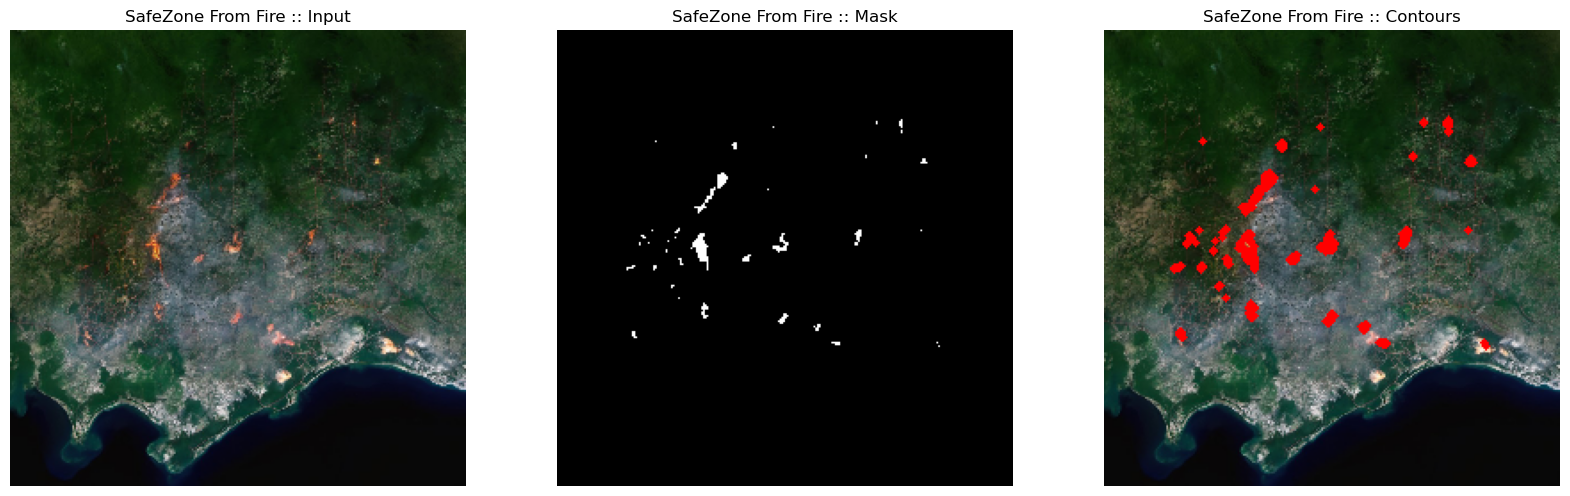

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

# 이미지 로드 및 전처리
img = cv2.imread('../test_2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))  # 크기 일치

t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
image = t(img)
image = image.to(device)

model.eval()

with torch.no_grad():
    image = image.unsqueeze(0)
    output = model(image)
    output = torch.sigmoid(output)

    threshold = 0.000001  # binary classification에 대한 일반적인 임계값
    binary_mask = (output > threshold).float()
    pred_mask = binary_mask.cpu().squeeze(0).squeeze(0).numpy()

# 마스크를 uint8로 변환
seg = (pred_mask * 255).astype(np.uint8)

# 메인 이미지 준비
main = img.copy()  # RGB 이미지 유지

# 외부 윤곽선 찾기
contours, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 윤곽선 그리기 (빨간색으로 단일 클래스 표시)
cv2.drawContours(main, contours, -1, (255, 0, 0), 4)  # 빨간색, 두께 2

# 결과 표시
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('SafeZone From Fire :: Input')
ax1.axis('off')

ax2.imshow(pred_mask, cmap='gray')
ax2.set_title('SafeZone From Fire :: Mask')
ax2.axis('off')

ax3.imshow(main)
ax3.set_title('SafeZone From Fire :: Contours')
ax3.axis('off')

plt.show()